# Analysing info about driver's licenses

Hello, i am Iza and this is simple analysis i made to get used to working with data in Python. My aim is to answer some questions using data about newly granted driver licences in Poland.

## About the data

Datasets come from dane.gov.pl website. They contain info about newly granted driver licenses in Poland in both 2022 and 2023. They contain month, age, sex and number of licenses granted. Unfortunately this dataset don't contain much information, but we can still do some interesting stuff with it!

## Table of contents

1. [Data load and setup](#1-data-load-and-setup)
2. [In what months were the most driver's licenses granted? Are their numbers significantly higher in the summer?](#2-in-what-months-were-the-most-drivers-licenses-granted-are-their-numbers-significantly-higher-in-the-summer)
3. Which voivodeships have the highest number of driving licenses obtained (per number of inhabitants)?
4. What is the difference in the number of driving licenses obtained between men and women? Does age play a factor here?
5. Which age groups get the most driving licenses?
6. How did the number of driving licenses obtained changed between 2022 and 2023? Is the difference significant?
7. Conclusion


## 1. Data load and setup

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os


In [63]:
csv_files_22 = [f for f in os.listdir('2022') if f.endswith('.csv')] 
csv_files_23 = [f for f in os.listdir('2023') if f.endswith('.csv')]
list1 = [] 
list2 = []

for file in csv_files_22:
    file_path = os.path.join('2022', file) 
    df = pd.read_csv(file_path, encoding='utf-8', sep='|')  
    list1.append(df)

for file in csv_files_23:
    file_path = os.path.join('2023', file)  
    df = pd.read_csv(file_path, encoding='utf-8', sep='|')  
    list2.append(df)


While working with this data i encountered peculiar problem. In files about march and november 2023 there is different separator and it caused problems (fixed it manually in csv's)

In [64]:
# changing list to dataframe 
df_2022 = pd.concat(list1, ignore_index=True)
df_2023 = pd.concat(list2, ignore_index=True)


In [65]:
df = pd.concat([df_2022, df_2023], ignore_index=True)
df[['YEAR', 'MONTH']] = df['DATA_MC'].str.split('-', expand=True)
df.set_index(['YEAR', 'MONTH'], inplace=True)
df.drop(columns='DATA_MC', inplace=True)
# translating polish columns
df.rename(columns={'KOD_WOJ' : 'VOIV_CODE', 'WOJEWODZTWO' : 'VOIVODESHIP', 'PLEC' : 'GENDER', 'WIEK' : 'AGE', 'LICZBA' : 'NUMBER'}, inplace=True)
df

VOIV_CODE              VOIVODESHIP GENDER  AGE  NUMBER
YEAR MONTH                                                        
2022 01             2        WOJ. DOLNOŚLĄSKIE      K   54       4
     01             2        WOJ. DOLNOŚLĄSKIE      K   47       5
     01             2        WOJ. DOLNOŚLĄSKIE      K   42       5
     01             2        WOJ. DOLNOŚLĄSKIE      K   20      89
     01             2        WOJ. DOLNOŚLĄSKIE      K   29      22
...               ...                      ...    ...  ...     ...
2023 12            32  WOJ. ZACHODNIOPOMORSKIE      M   18     275
     12            32  WOJ. ZACHODNIOPOMORSKIE      M   20      20
     12            32  WOJ. ZACHODNIOPOMORSKIE      M   19      51
     12            32  WOJ. ZACHODNIOPOMORSKIE      M   41       3
     12            32  WOJ. ZACHODNIOPOMORSKIE      M   43       4

[30592 rows x 5 columns]

As we can see data is fairly simple, but nevertheless we can answer some questions with it :)

## 2. In what months were the most driver's licenses granted? Are their numbers significantly higher in the summer?

In [66]:
num_months = df.groupby(['YEAR', 'MONTH'])['NUMBER'].sum().to_frame()
num_months


NUMBER
YEAR MONTH        
2022 01      27012
     02      27907
     03      32601
     04      26385
     05      26505
     06      26473
     07      24892
     08      25230
     09      27334
     10      29929
     11      29504
     12      26791
2023 01      28385
     02      26273
     03      30403
     04      24373
     05      23823
     06      24521
     07      24700
     08      24294
     09      20476
     10      24462
     11      19605
     12      25005

At a first glance those numbers do not differ significantly. Let's see it on a chart to analyze better!

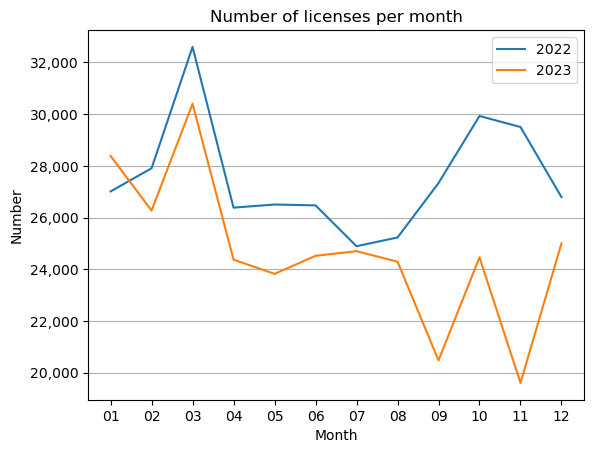

In [67]:
#resreting index for easier plotting 
num_months.reset_index(inplace=True)

for year in num_months['YEAR'].unique():
    subset = num_months[num_months['YEAR'] == year]
    plt.plot(subset['MONTH'], subset['NUMBER'], label=year)
    
plt.legend()
plt.title('Number of licenses per month')
plt.xlabel('Month')
plt.ylabel('Number')
plt.grid(axis='y')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}'))
plt.show()



Thanks to the chart, we can draw unexpected conclusions:
- the number of driver's licenses granted is quite significantly higher in 2022 than in 2023
- the month in which the most driver's licenses were granted is surprisingly March, and this is true in both 22 and 23. The high number is also in October
- in 2022 the least number of driver's licenses were granted during the vacation season, and in 2023 in November and September. 

All in all, it might be a good idea to book your exam for March! 
